# Import Libraries & Dataset


In [79]:
!pip install -q catboost

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
%matplotlib inline

In [81]:
dtrain = pd.read_csv('/content/sample_data/train.csv')
dtest = pd.read_csv('/content/sample_data/test.csv')


In [82]:
dtrain.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,1,Martin,727.0,Spain,Male,38.0,2,62276.99,1,Yes,Yes,59280.79,No,4,DIAMOND,757,0
1,2,Chinweuba,529.0,France,Female,29.0,8,0.00,2,Yes,NaN,19842.11,No,3,SILVER,476,0
2,3,Clapp,589.0,France,Female,50.0,4,0.00,2,No,Yes,182076.97,No,4,PLATINUM,441,0
3,4,Boni,515.0,France,Male,40.0,0,109542.29,1,Yes,Yes,166370.81,No,5,GOLD,312,0
4,5,Jamieson,528.0,Spain,Male,43.0,7,97473.87,2,Yes,Yes,159823.16,No,3,PLATINUM,654,0


In [83]:
dtest.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,2001,Ugonna,693,Germany,Male,44,5,124601.58,2,Yes,Yes,46998.13,Yes,2,SILVER,408
1,2002,Nebeolisa,607,Germany,Male,29,7,102609.00,1,Yes,No,163257.44,No,5,DIAMOND,800
2,2003,Tsai,689,Spain,Male,73,1,108555.07,1,No,Yes,167969.15,No,1,PLATINUM,623
3,2004,Downie,660,France,Female,38,5,110570.78,2,Yes,No,195906.59,No,1,SILVER,472
4,2005,Morehead,503,France,Male,38,1,0.00,2,Yes,Yes,95153.24,No,2,DIAMOND,433


# EDA

In [84]:
numcols = [var for var in dtrain.columns if dtrain[var].dtype != 'object']
catcols = [var for var in dtrain.columns if dtrain[var].dtype == 'object']

print("Numerical: ", numcols)
print("Categorical: ", catcols)

Numerical:  ['ID', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned', 'Exited']
Categorical:  ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'Card Type']


Numcols Visual

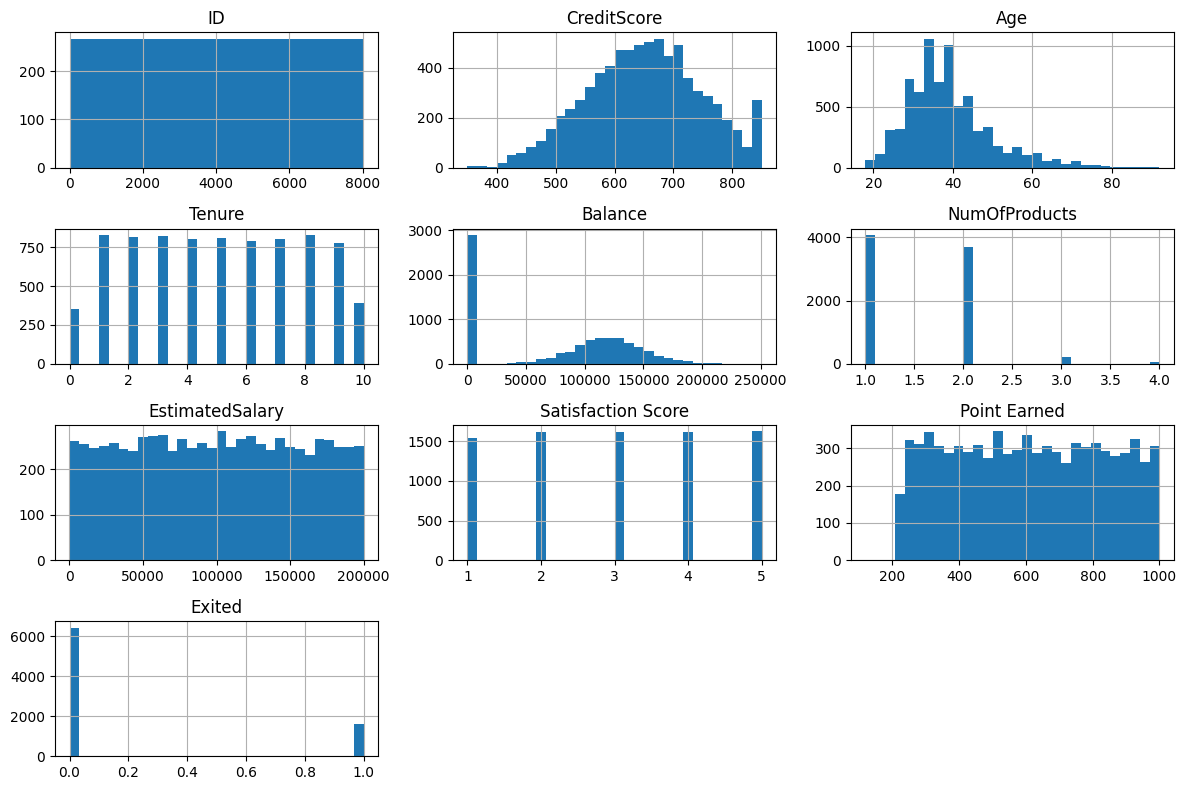

In [85]:
dtrain[numcols].hist(bins=30, figsize=(12,8));
plt.tight_layout()
plt.show()

Hilangkan data tidak terpakai

In [86]:
while('Surname' in catcols):
    catcols.remove('Surname')

catcols

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'Card Type']

Catcols Visual

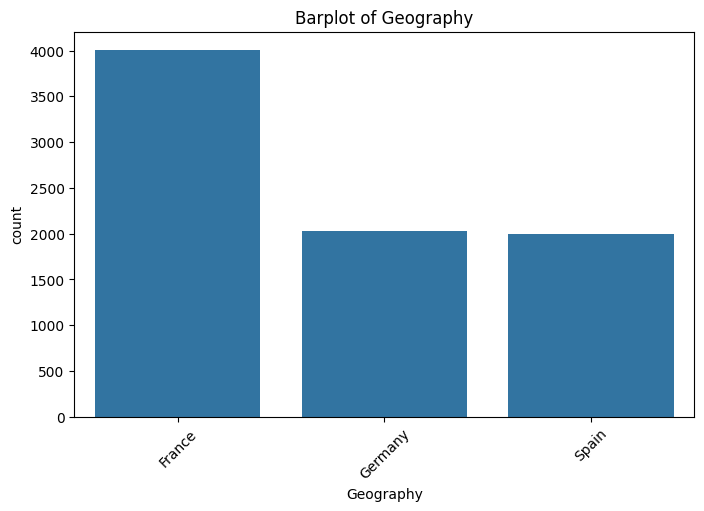

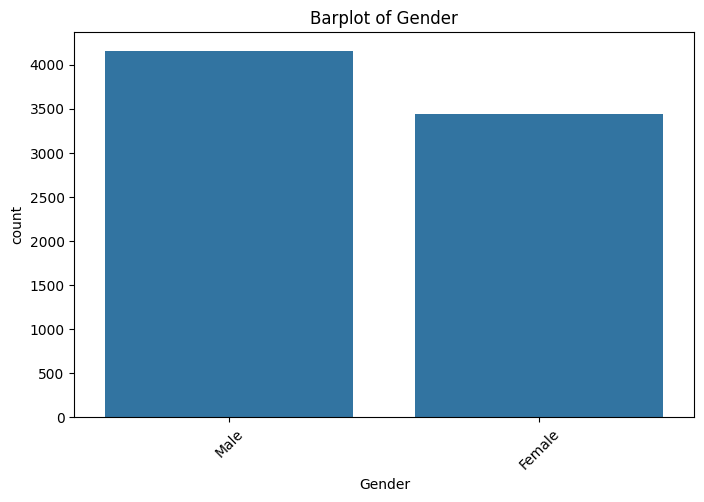

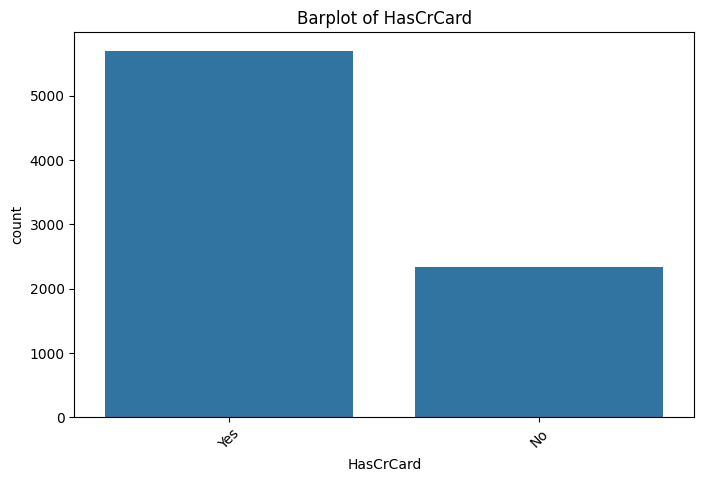

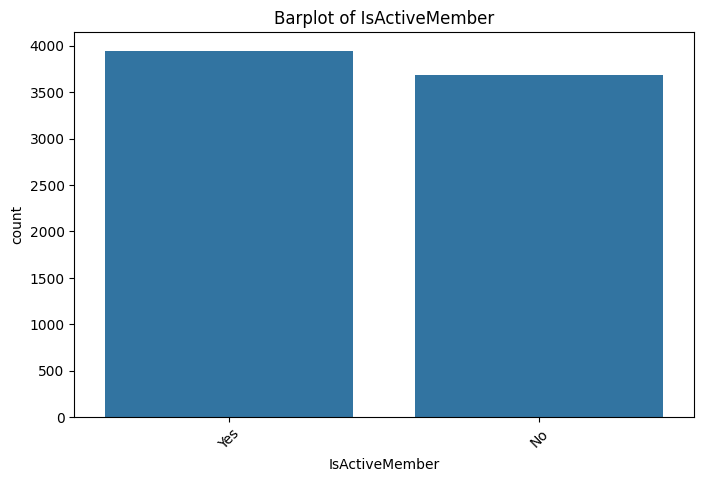

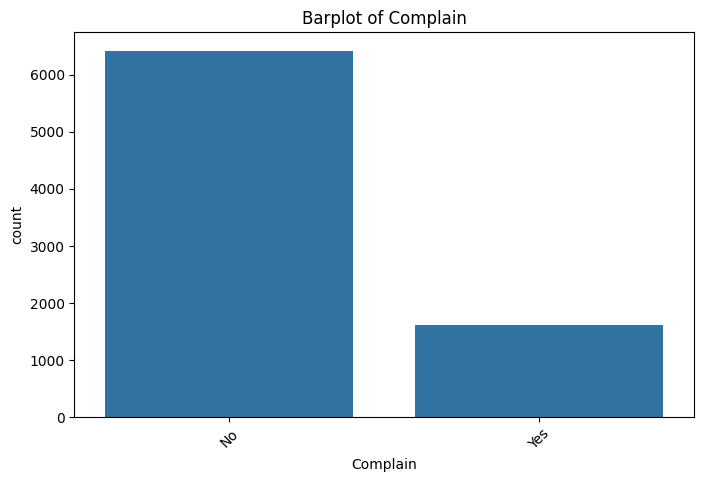

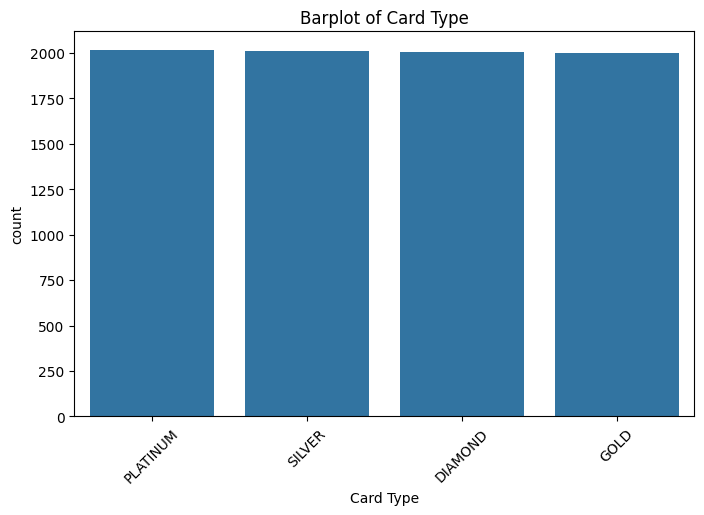

In [87]:
for col in catcols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=dtrain, x=col, order=dtrain[col].value_counts().index)
    plt.title(f'Barplot of {col}')
    plt.xticks(rotation=45)
    plt.show()

Encode Catcols

In [88]:
dtrain2 = dtrain.copy() # copy the original dataframe

for col in catcols:
    le = LabelEncoder()

    dtrain2[col] = le.fit_transform(dtrain2[col])

dtrain.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,1,Martin,727.0,Spain,Male,38.0,2,62276.99,1,Yes,Yes,59280.79,No,4,DIAMOND,757,0
1,2,Chinweuba,529.0,France,Female,29.0,8,0.00,2,Yes,NaN,19842.11,No,3,SILVER,476,0
2,3,Clapp,589.0,France,Female,50.0,4,0.00,2,No,Yes,182076.97,No,4,PLATINUM,441,0
3,4,Boni,515.0,France,Male,40.0,0,109542.29,1,Yes,Yes,166370.81,No,5,GOLD,312,0
4,5,Jamieson,528.0,Spain,Male,43.0,7,97473.87,2,Yes,Yes,159823.16,No,3,PLATINUM,654,0


In [89]:
dtrain2.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,1,Martin,727.0,2,1,38.0,2,62276.99,1,1,1,59280.79,0,4,0,757,0
1,2,Chinweuba,529.0,0,0,29.0,8,0.00,2,1,2,19842.11,0,3,3,476,0
2,3,Clapp,589.0,0,0,50.0,4,0.00,2,0,1,182076.97,0,4,2,441,0
3,4,Boni,515.0,0,1,40.0,0,109542.29,1,1,1,166370.81,0,5,1,312,0
4,5,Jamieson,528.0,2,1,43.0,7,97473.87,2,1,1,159823.16,0,3,2,654,0


# Feature Engineering & Data Preprocessing

Train Missing Values

In [90]:
missing = dtrain.isna().sum().sort_values(ascending=False)
missing

,0
Age,442
CreditScore,427
Gender,423
IsActiveMember,402
EstimatedSalary,366
ID,0
Point Earned,0
Card Type,0
Satisfaction Score,0
Complain,0


Test Missing Values

In [91]:
dtest.isna().sum().sort_values(ascending=False)

,0
ID,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0


Handling Numcol missing values

In [92]:
dtrain_num = [col for col in dtrain.columns if dtrain[col].dtype != 'object']
dtrain_num

['ID',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Satisfaction Score',
 'Point Earned',
 'Exited']

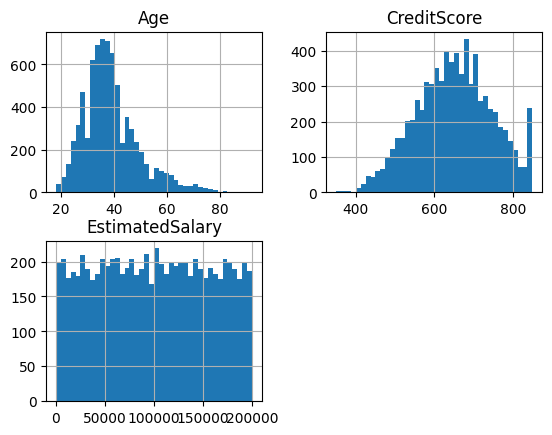

In [93]:
dtrain[['Age', 'CreditScore', 'EstimatedSalary']].hist(bins=40);

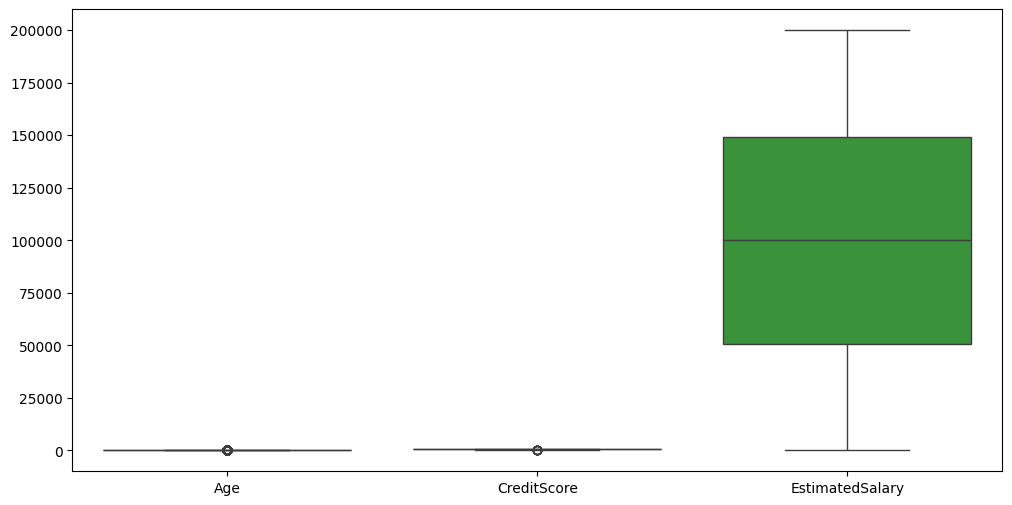

In [94]:
miscol = ['Age', 'CreditScore', 'EstimatedSalary']
plt.figure(figsize=(12,6))
sns.boxplot(data=dtrain[miscol])
plt.show()

Handling Age

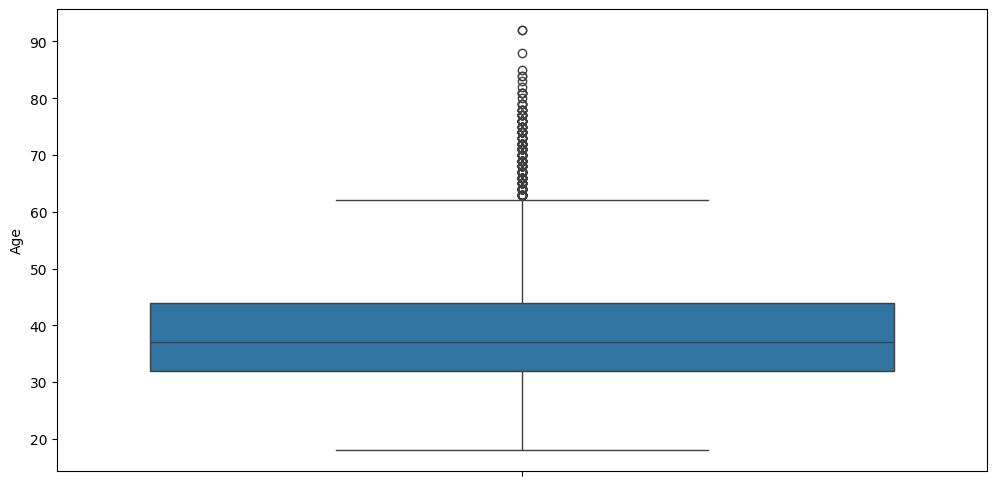

In [95]:
plt.figure(figsize=(12,6))
sns.boxplot(data=dtrain['Age'])
plt.show()

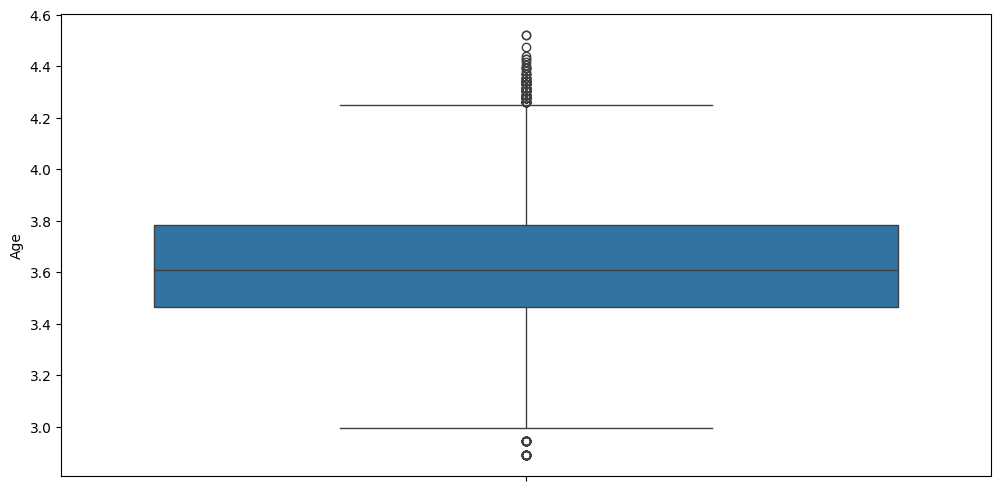

In [96]:
dtrain['Age'] = np.log(dtrain['Age'])

plt.figure(figsize=(12,6))
sns.boxplot(data=dtrain['Age'])
plt.show()

Handling CreditScore

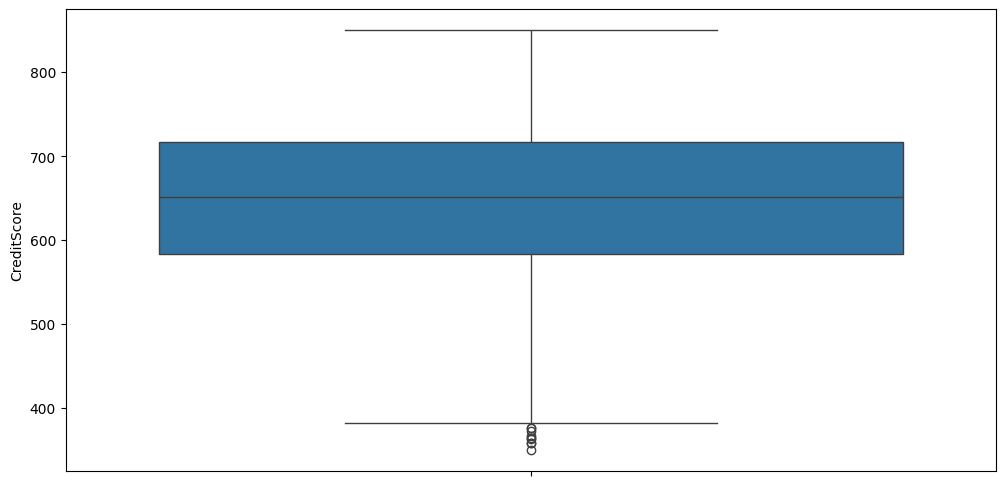

In [97]:
plt.figure(figsize=(12,6))
sns.boxplot(data=dtrain['CreditScore'])
plt.show()

Handling EstimatedSalary

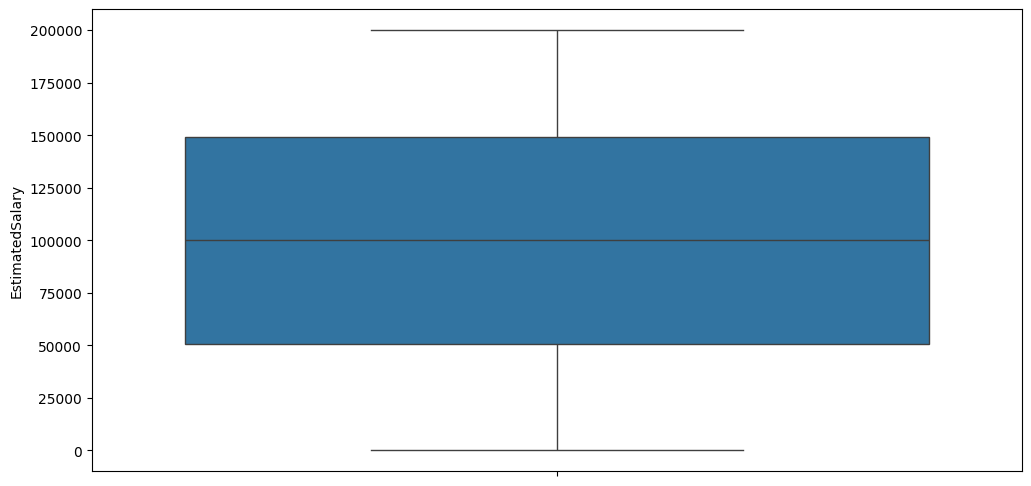

In [98]:
plt.figure(figsize=(12,6))
sns.boxplot(data=dtrain['EstimatedSalary'])
plt.show()

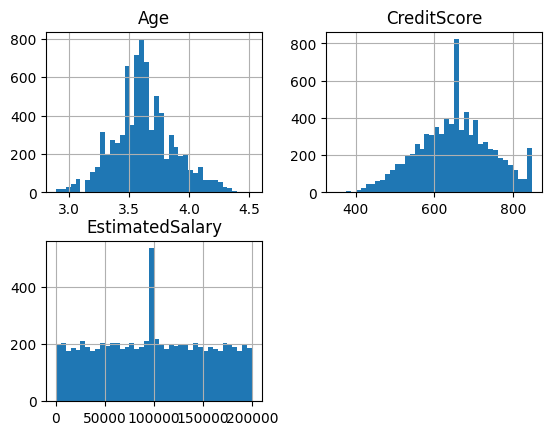

In [99]:
dtrain['Age'].fillna(dtrain['Age'].median(), inplace=True)
dtrain['CreditScore'].fillna(dtrain['CreditScore'].mean(), inplace=True)
dtrain['EstimatedSalary'].fillna(dtrain['EstimatedSalary'].mean(), inplace=True)

dtrain[['Age', 'CreditScore', 'EstimatedSalary']].hist(bins=40);

Handling Catcols missing values


In [100]:
missing = dtrain.isna().sum().sort_values(ascending=False)
missing

,0
Gender,423
IsActiveMember,402
ID,0
HasCrCard,0
Point Earned,0
Card Type,0
Satisfaction Score,0
Complain,0
EstimatedSalary,0
NumOfProducts,0


Cek Duplikat

In [101]:
dtrain.duplicated().sum()

0

Encoding Catcols

In [102]:
for col in catcols:
    print(dtrain[col].value_counts())
    print('-'*50)

Geography
France     4006
Germany    2027
Spain      1997
Name: count, dtype: int64
--------------------------------------------------
Gender
Male      4162
Female    3445
Name: count, dtype: int64
--------------------------------------------------
HasCrCard
Yes    5700
No     2330
Name: count, dtype: int64
--------------------------------------------------
IsActiveMember
Yes    3948
No     3680
Name: count, dtype: int64
--------------------------------------------------
Complain
No     6422
Yes    1608
Name: count, dtype: int64
--------------------------------------------------
Card Type
PLATINUM    2017
SILVER      2010
DIAMOND     2003
GOLD        2000
Name: count, dtype: int64
--------------------------------------------------


In [103]:
le = LabelEncoder()

for col in catcols:
    le = LabelEncoder()

    dtrain[col] = le.fit_transform(dtrain[col])
    dtest[col] = le.transform(dtest[col])

dtrain.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,1,Martin,727.0,2,1,3.637586,2,62276.99,1,1,1,59280.79,0,4,0,757,0
1,2,Chinweuba,529.0,0,0,3.367296,8,0.00,2,1,2,19842.11,0,3,3,476,0
2,3,Clapp,589.0,0,0,3.912023,4,0.00,2,0,1,182076.97,0,4,2,441,0
3,4,Boni,515.0,0,1,3.688879,0,109542.29,1,1,1,166370.81,0,5,1,312,0
4,5,Jamieson,528.0,2,1,3.761200,7,97473.87,2,1,1,159823.16,0,3,2,654,0


In [104]:
dtest.head()

,ID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,2001,Ugonna,693,1,1,44,5,124601.58,2,1,1,46998.13,1,2,3,408
1,2002,Nebeolisa,607,1,1,29,7,102609.00,1,1,0,163257.44,0,5,0,800
2,2003,Tsai,689,2,1,73,1,108555.07,1,0,1,167969.15,0,1,2,623
3,2004,Downie,660,0,0,38,5,110570.78,2,1,0,195906.59,0,1,3,472
4,2005,Morehead,503,0,1,38,1,0.00,2,1,1,95153.24,0,2,0,433


# ML Training

In [105]:
dtrain.drop(['ID', 'Surname'], axis=1, inplace=True)

X = dtrain.drop('Exited',axis=1)
y = dtrain['Exited']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.27,
    random_state=111
)
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

model = CatBoostClassifier(iterations=500, learning_rate=0.2, depth=6, verbose=0)
model.fit(X_train, y_train)


In [106]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Menentukan parameter yang akan diuji dalam GridSearchCV
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000]
}

# Membuat model awal tanpa parameter spesifik
cat_model = CatBoostClassifier(verbose=0)

# Melakukan pencarian hyperparameter terbaik
grid_search = GridSearchCV(cat_model, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print("Best parameters:", grid_search.best_params_)

# Menggunakan parameter terbaik untuk model akhir
best_params = grid_search.best_params_
model = CatBoostClassifier(**best_params, verbose=0)
model.fit(X_train, y_train)


Best parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.01}


# Evaluation


In [107]:
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_val, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy:  0.9990779160903642
ROC AUC Score:  0.9992674915172539

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1746
           1       1.00      1.00      1.00       423

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169



In [108]:
print(f'F1-score: {f1_score(y_val, y_pred)}')

F1-score: 0.9976415094339622


# Submission

In [109]:
dtest.drop(['ID', 'Surname'], axis=1, inplace=True)

dtest.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,693,1,1,44,5,124601.58,2,1,1,46998.13,1,2,3,408
1,607,1,1,29,7,102609.00,1,1,0,163257.44,0,5,0,800
2,689,2,1,73,1,108555.07,1,0,1,167969.15,0,1,2,623
3,660,0,0,38,5,110570.78,2,1,0,195906.59,0,1,3,472
4,503,0,1,38,1,0.00,2,1,1,95153.24,0,2,0,433


In [110]:
dtest['Exited'] = model.predict(dtest)

dtest.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,693,1,1,44,5,124601.58,2,1,1,46998.13,1,2,3,408,1
1,607,1,1,29,7,102609.00,1,1,0,163257.44,0,5,0,800,0
2,689,2,1,73,1,108555.07,1,0,1,167969.15,0,1,2,623,0
3,660,0,0,38,5,110570.78,2,1,0,195906.59,0,1,3,472,0
4,503,0,1,38,1,0.00,2,1,1,95153.24,0,2,0,433,0


In [111]:
dtest['Exited'].value_counts()

,count
Exited,
0,1556
1,444


In [112]:
submission = pd.read_csv('/content/sample_data/sample_submission.csv')

submission

,ID,Exited
0,2001,1
1,2002,0
2,2003,0
3,2004,1
4,2005,0
...,...,...
1995,3996,1
1996,3997,0
1997,3998,1
1998,3999,0


In [113]:
submission['Exited'] = dtest['Exited']

submission

,ID,Exited
0,2001,1
1,2002,0
2,2003,0
3,2004,0
4,2005,0
...,...,...
1995,3996,1
1996,3997,0
1997,3998,0
1998,3999,0


In [114]:
submission.to_csv('ItzHanif.csv', index=False)

myhasil = pd.read_csv('/content/ItzHanif.csv')

myhasil

,ID,Exited
0,2001,1
1,2002,0
2,2003,0
3,2004,0
4,2005,0
...,...,...
1995,3996,1
1996,3997,0
1997,3998,0
1998,3999,0
